### Overview

Goal: predict cancer type based on integrated CPTAC omics data

data url:
https://figshare.com/s/7ffe48478ec907b36dfb

CNV, proteomics, transcriptomics are X  
cancer_type (10) is y, from sample file

This notebook reads a latent feature file from the  
VAE in CPTAC_VAE_v0.ipynb for each datatype  
and the prediction targets from the sample file  
then makes a categorical cancer type prediction  
with a tabular transformer

model template:
https://keras.io/examples/structured_data/tabtransformer/

#### Schematic of experiment

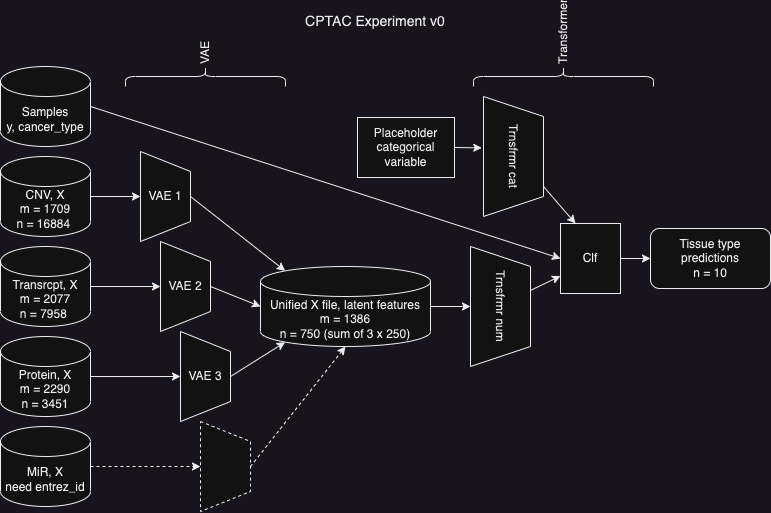

In [296]:
from IPython.display import Image
Image(filename='CPTAC_schematic_v0.png',
      # width=600,
      # height=400
     )

### Setup

In [19]:
import pandas as pd
pd.set_option('display.max_rows', 300)

In [21]:
# Conda envrionment, Apple M1
trsfrmr_conda_env = pd.read_csv('CPTAC_trsfrmr_conda_packages.tsv', sep = '\t',
           header = None)
headers = ['Name', 'Version', 'Build', 'Channel']
trsfrmr_conda_env.columns = headers
trsfrmr_conda_env

,Name,Version,Build,Channel
0,absl-py,1.4.0,pypi_0,pypi
1,aiofiles,22.1.0,pyhd8ed1ab_0,conda-forge
2,aiosqlite,0.18.0,pyhd8ed1ab_0,conda-forge
3,anyio,3.6.2,pyhd8ed1ab_0,conda-forge
4,appnope,0.1.3,pyhd8ed1ab_0,conda-forge
5,argon2-cffi,21.3.0,pyhd8ed1ab_0,conda-forge
6,argon2-cffi-bindings,21.2.0,py39h02fc5c5_3,conda-forge
7,arrow,1.2.3,pypi_0,pypi
8,asttokens,2.2.1,pyhd8ed1ab_0,conda-forge
9,astunparse,1.6.3,pypi_0,pypi


In [22]:
len(trsfrmr_conda_env)

250

#### Model template
https://keras.io/examples/structured_data/tabtransformer/

### Imports

In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import collections

/Users/karlberb/miniforge3/envs/trnsfrmr/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Data prep

In [4]:
samples = pd.read_csv('data/samples.csv')
samples.index = samples.improve_sample_id
y = pd.DataFrame(samples['cancer_type'])

In [5]:
cnv = pd.read_csv('latent_features/cnv_latent.tsv', sep = '\t',
                   index_col = 0)
prt = pd.read_csv('latent_features/proteomics_latent.tsv', sep = '\t',
                   index_col = 0)
trs = pd.read_csv('latent_features/transcriptomics_latent.tsv', sep = '\t',
                   index_col = 0)

In [55]:
# Combined numeric feature and y target (cancer_type) object
y_X = pd.concat([y, cnv, prt, trs], axis=1, join='inner')
print('Original sample count', y_X.shape[0])

y_X['plchldr_cat'] = '1' # Placeholder column for categorical features
y_X['fnlwgt'] = 1. # optional wieght variable - increase for rare classes

# Take out 100 random samples for validation
n_vld = 100
smpl_srs = y_X.index.to_series().sample(n_vld)
validation_set = y_X.loc[smpl_srs, :]

train_test_set = y_X.loc[~y_X.index.isin(validation_set.index)]
num_classes = len(train_test_set.cancer_type.unique())
print('Validation sum check ', len(train_test_set)+len(validation_set))

Original sample count 1386
Validation sum check  1386


### Transformer setup

In [56]:
# Cross validation insertion point
train_data = train_test_set.sample(int(len(train_test_set)*.75))
test_data = train_test_set.loc[~train_test_set.index.isin(train_data.index)]

In [57]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [58]:
CSV_HEADER = y_X.columns.to_list()

In [59]:
NUMERIC_FEATURE_NAMES = list(y_X.columns[1:-2])

In [60]:
len(NUMERIC_FEATURE_NAMES)

750

In [61]:
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "plchldr_cat": sorted(list(train_data["plchldr_cat"].unique())),
}

In [62]:
len(CATEGORICAL_FEATURES_WITH_VOCABULARY)

1

In [63]:
WEIGHT_COLUMN_NAME = "fnlwgt"

In [64]:
TARGET_FEATURE_NAME = 'cancer_type'

In [65]:
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

In [66]:
TARGET_LABELS = y_X.cancer_type.unique().tolist()

In [67]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [68]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)

def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()

/Users/karlberb/miniforge3/envs/trnsfrmr/lib/python3.9/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [69]:
def run_experiment(
    model,            # <--- toggle point for baseline MLP or tabular transformer
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # ~~~~  Multi-class categorical prediction  ~~~~
    model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

In [70]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    # print()
    return inputs

In [71]:
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

In [72]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [73]:
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

In [74]:
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

In [75]:
# MLP
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # ~~~~  Add a sigmoid as a binary classifer ~~~~
    # outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    
    # ~~~~  Softmax for multi-class classifer ~~~~
    outputs = layers.Dense(units=num_classes, activation="softmax", name="softmax")(features)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
# keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

Total model weights: 3535879


In [76]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...


2023-07-17 16:02:35.979643: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15


/Users/karlberb/miniforge3/envs/trnsfrmr/lib/python3.9/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-07-17 16:02:37.777139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-17 16:02:49.371930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 901 of 10000
2023-07-17 16:02:59.640022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 954 of 10000
2023-07-17 16:03:02.009744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


      4/Unknown - 27s 281ms/step - loss: 1.8169 - accuracy: 0.6006WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2023-07-17 16:03:05.096663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 29s 1s/step - loss: 1.8169 - accuracy: 0.6006 - val_loss: 1.4600 - val_accuracy: 0.7640
Epoch 2/15
4/4 [==============================] - 1s 155ms/step - loss: 1.0884 - accuracy: 0.8745 - val_loss: 1.1696 - val_accuracy: 0.8634
Epoch 3/15
4/4 [==============================] - 1s 154ms/step - loss: 0.5535 - accuracy: 0.9263 - val_loss: 0.3864 - val_accuracy: 0.9224
Epoch 4/15
4/4 [==============================] - 1s 153ms/step - loss: 0.1674 - accuracy: 0.9678 - val_loss: 0.8664 - val_accuracy: 0.8571
Epoch 5/15
4/4 [==============================] - 1s 137ms/step - loss: 0.1480 - accuracy: 0.9564 - val_loss: 0.2408 - val_accuracy: 0.8727
Epoch 6/15
4/4 [==============================] - 1s 163ms/step - loss: 0.0981 - accuracy: 0.9751 - val_loss: 0.1514 - val_accuracy: 0.9503
Epoch 7/15
4/4 [==============================] - 0s 130ms/step - loss: 0.0272 - accuracy: 0.9896 - val_loss: 0.7647 - val_accuracy: 0.7981
Epoch 8/15
4/4 [=================

### MLP predictions

In [77]:
validation_set

,cancer_type,ltnt_cnv_0,ltnt_cnv_1,ltnt_cnv_2,ltnt_cnv_3,ltnt_cnv_4,ltnt_cnv_5,ltnt_cnv_6,ltnt_cnv_7,ltnt_cnv_8,...,ltnt_trs_242,ltnt_trs_243,ltnt_trs_244,ltnt_trs_245,ltnt_trs_246,ltnt_trs_247,ltnt_trs_248,ltnt_trs_249,plchldr_cat,fnlwgt
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
109820.0,Breast carcinoma,0.000000,0.0,0.000000,1.433715,0.000000,0.000000,0.0,6.907877,4.122471,...,0.0,0.448051,0.518651,0.515649,0.876546,0.513258,0.083375,0.000000,1,1.0
108270.0,Breast carcinoma,0.000000,0.0,0.000000,1.398782,0.000000,1.031150,0.0,6.901609,4.713804,...,0.0,0.437247,0.506141,0.481366,0.811322,0.425224,0.000000,0.000000,1,1.0
109964.0,Breast carcinoma,0.000000,0.0,0.115932,1.860882,0.000000,1.078823,0.0,5.853739,4.319950,...,0.0,0.466553,0.507196,0.497130,0.870872,0.554220,0.097657,0.000000,1,1.0
108165.0,Breast carcinoma,0.000000,0.0,0.000000,1.130291,0.000000,1.189532,0.0,7.821920,5.560207,...,0.0,0.511565,0.564085,0.635782,1.039949,0.658557,0.152952,0.000000,1,1.0
110419.0,Pancreatic ductal adenocarcinoma,0.026880,0.0,0.000000,1.405521,0.000000,1.022672,0.0,7.507570,5.328773,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.733532,0.864370,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110145.0,Colon adenocarcinoma,0.000000,0.0,0.000000,2.576671,0.000000,0.000000,0.0,5.173397,4.261923,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.613996,0.577007,1,1.0
109376.0,Lung adenocarcinoma,0.000000,0.0,0.000000,0.960527,0.000000,1.416421,0.0,7.516705,4.300665,...,0.0,0.530324,0.497336,0.450473,0.647615,0.492134,0.000000,0.000000,1,1.0
110385.0,Pancreatic ductal adenocarcinoma,0.000000,0.0,0.000000,1.336474,0.000000,1.101984,0.0,7.383413,5.456665,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.753509,0.857809,1,1.0


In [116]:
# toggle number of predictions
n_vld_smpls_to_check = 10

In [117]:
smpl_srs = validation_set.index.to_series().sample(n_vld_smpls_to_check)

In [118]:
smpl_srs

improve_sample_id
108270.0    108270.0
110381.0    110381.0
110338.0    110338.0
109153.0    109153.0
108258.0    108258.0
108953.0    108953.0
109877.0    109877.0
109926.0    109926.0
110409.0    110409.0
109937.0    109937.0
Name: improve_sample_id, dtype: float64

In [137]:
truth_list = []
prediction_list = []
# for isi in smpl_srs: # isi is improve sample id, for random sample validation set
for i in list(range(10)):
# for i in list(range(len(validation_set))):

    hold_out = pd.DataFrame(validation_set.iloc[i]).T
    improve_samble_id = hold_out.index[0]
    truth_val = hold_out.loc[improve_samble_id, 'cancer_type']
    truth_list.append(truth_val)
    hold_out = hold_out.drop(columns=hold_out.columns[0]) # Label is always pos 0 here
    # to prediction formatting function
    ch_lst = []
    val_lst = []
    for clmn_hdr in hold_out.columns:
        ch_lst.append(clmn_hdr)
        val_lst.append(hold_out[clmn_hdr][improve_samble_id])
        result_dict = dict(zip(ch_lst, val_lst)) 
        
        # break
    result_dict.pop('fnlwgt')
    input_dict = {name: tf.convert_to_tensor([value]) for name,value in result_dict.items()}
    prediction_list.append(baseline_model.predict(input_dict))
    print(improve_samble_id, ' predicted')
    # break

1/1 [==============================] - 0s 346ms/step
109820.0  predicted
1/1 [==============================] - 0s 330ms/step
108270.0  predicted
1/1 [==============================] - 0s 353ms/step
109964.0  predicted
1/1 [==============================] - 0s 335ms/step
108165.0  predicted
1/1 [==============================] - 0s 330ms/step
110419.0  predicted
1/1 [==============================] - 0s 330ms/step
110381.0  predicted
1/1 [==============================] - 0s 329ms/step
108458.0  predicted
1/1 [==============================] - 0s 323ms/step
108252.0  predicted
1/1 [==============================] - 0s 321ms/step
109714.0  predicted
1/1 [==============================] - 0s 332ms/step
109137.0  predicted


In [138]:
human_readable_predictions = []
for p in prediction_list:
    human_readable_predictions.append(TARGET_LABELS[np.argmax(p)])
    # print(p)
    # break

In [139]:
for i, truth_val in enumerate(truth_list):
    print(truth_val, human_readable_predictions[i])
    # break

Breast carcinoma Breast carcinoma
Breast carcinoma Breast carcinoma
Breast carcinoma Breast carcinoma
Breast carcinoma Breast carcinoma
Pancreatic ductal adenocarcinoma Head and neck squamous cell carcinoma
Pancreatic ductal adenocarcinoma Pancreatic ductal adenocarcinoma
Endometrial carcinoma Endometrial carcinoma
Breast carcinoma Breast carcinoma
Breast carcinoma Breast carcinoma
Lung squamous cell carcinoma Lung squamous cell carcinoma


In [140]:
import sklearn.metrics

In [144]:
len(truth_list)

10

In [145]:
len(prediction_list)

10

In [146]:
len(human_readable_predictions)

10

In [147]:
sklearn.metrics.accuracy_score(truth_list, human_readable_predictions)

0.9

In [ ]:
# End MLP version zero, ~90% accurate at predicting 
# tissue-of-origin based on latent features of
# CNV, proteomics, and gene expression

### Transformer

In [148]:
# Multi-categorical

def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    # outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    
    # ~~~~  Softmax for multi-class classifer ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <---
    outputs = layers.Dense(units=num_classes, activation="softmax", name="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
# keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

/Users/karlberb/miniforge3/envs/trnsfrmr/lib/python3.9/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Total model weights: 2373287


In [149]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15


/Users/karlberb/miniforge3/envs/trnsfrmr/lib/python3.9/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-07-17 20:03:23.946297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      4/Unknown - 6s 542ms/step - loss: 2.9394 - accuracy: 0.5985WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2023-07-17 20:03:29.808536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 9s 2s/step - loss: 2.9394 - accuracy: 0.5985 - val_loss: 5.7565 - val_accuracy: 0.4658
Epoch 2/15
4/4 [==============================] - 1s 263ms/step - loss: 0.7891 - accuracy: 0.8579 - val_loss: 0.9627 - val_accuracy: 0.7453
Epoch 3/15
4/4 [==============================] - 1s 263ms/step - loss: 0.5865 - accuracy: 0.8963 - val_loss: 4.6863 - val_accuracy: 0.4379
Epoch 4/15
4/4 [==============================] - 1s 274ms/step - loss: 0.8120 - accuracy: 0.9025 - val_loss: 2.3591 - val_accuracy: 0.6335
Epoch 5/15
4/4 [==============================] - 1s 253ms/step - loss: 0.2277 - accuracy: 0.9627 - val_loss: 1.2014 - val_accuracy: 0.7205
Epoch 6/15
4/4 [==============================] - 1s 245ms/step - loss: 0.1697 - accuracy: 0.9678 - val_loss: 0.9089 - val_accuracy: 0.8416
Epoch 7/15
4/4 [==============================] - 1s 203ms/step - loss: 0.0598 - accuracy: 0.9834 - val_loss: 1.6917 - val_accuracy: 0.7112
Epoch 8/15
4/4 [==================

In [150]:
# Make 100 predictions on validation set,
# Multi-categorical modified Tabular Transformer
truth_list = []
prediction_list = []
for i in list(range(len(validation_set))):

    hold_out = pd.DataFrame(validation_set.iloc[i]).T
    improve_samble_id = hold_out.index[0]
    truth_val = hold_out.loc[improve_samble_id, 'cancer_type']
    truth_list.append(truth_val)
    hold_out = hold_out.drop(columns=hold_out.columns[0])

    ch_lst = []
    val_lst = []
    for clmn_hdr in hold_out.columns:
        ch_lst.append(clmn_hdr)
        val_lst.append(hold_out[clmn_hdr][improve_samble_id])
        result_dict = dict(zip(ch_lst, val_lst)) 
        
        # break
    result_dict.pop('fnlwgt')
    input_dict = {
        name: tf.convert_to_tensor(
            [value]) for name,value in result_dict.items()}
    prediction_list.append(tabtransformer_model.predict(input_dict)) # <--- replaced MLP
    # print(improve_samble_id, ' predicted')
human_readable_predictions = []
for p in prediction_list:
    human_readable_predictions.append(TARGET_LABELS[np.argmax(p)])
sklearn.metrics.accuracy_score(truth_list, human_readable_predictions)

2023-07-17 20:10:46.964207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 338ms/step


0.8

In [ ]:
# 80%
# MLP scores ~10% higher